### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
month, alive = np.loadtxt('data/retention-example.csv', dtype='object', delimiter=',', unpack=True, skiprows=1) 
month = month.astype(int)
alive = alive.astype(float)

### Introduction

### Sum of Squared Error Minimization

The simplest and most intuitive way to predict the retention rate (curve) using a single cohort data of active customers from acquisition to the end of an observed period is by using the sum of squared error minimization method. 

This model is based on the pattern of **monthly losses** and the **number of survivors at the end of the observed period**. For the cohort data provided, we are looking at whether the customers are going to churn in any of the given months or survive until the end of the period. 

- **Objective**: Minimize the sum of squared errors: $\Sigma_{m = 1}^{j}\left(E(L_{m}) - L_{m}\right)^{2} + (E(A_{j}) - A_{j})^{2}$
- **Decision Variable**: Expected Monthly Retention Rate ($E(r)$)
- **Bounds**: $0 \le E(r) \ge 1$ 

#### Non-linear Least Square - 1 Customer Segment

In [3]:
# Observed retention curve
retention = alive/alive[0]
# Monthly loss
loss = alive[:-1] - alive[1:]

In [4]:
from scipy.optimize import minimize

def square_error(x):
    e_retention = np.ones_like(retention) * (x**month) # Expected monthly retention rate
    e_churn = e_retention[:-1] - e_retention[1:] # Expected monthly churn rate
    en_loss = e_churn * alive[0] # Expected number of losses / month
    loss_error = np.sum((en_loss - loss)**2) # Sum of square of error - expected and actual loss
    survivor_error = ((e_retention[-1] * alive[0]) - alive[-1])**2 # Sum of square of error - expected and actual survivors at the end of the period
    return loss_error + survivor_error

x_guess = 0.94
res = minimize(square_error, x_guess)
print('Predicted Monthly Retention Rate =', f'{res.x[0]:0.2%}')
print('Sum of Squared Errors =', f'{res.fun:0.0f}')

Predicted Monthly Retention Rate = 94.84%
Sum of Squared Errors = 272850400


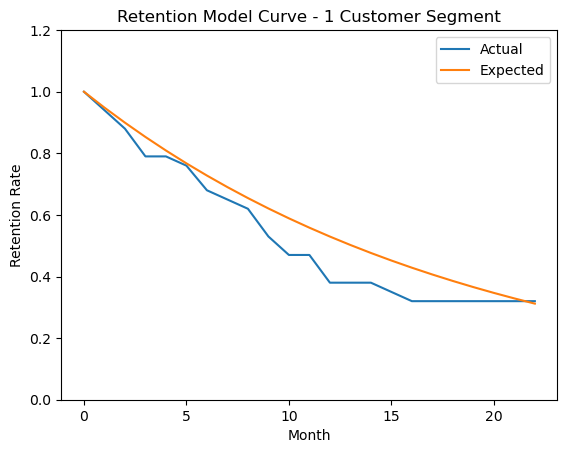

In [5]:
plt.plot(month, retention, label="Actual")
plt.plot(month, np.ones_like(retention) * (res.x**month), label="Expected")
plt.title('Retention Model Curve - 1 Customer Segment')
plt.xlabel("Month")
plt.ylabel("Retention Rate")
plt.ylim((0,1.2))
plt.legend()

#### Non-linear Least Square - 2 Customer Segments

In [6]:
# Observed retention curve
retention = alive/alive[0]
# Monthly loss
loss = alive[:-1] - alive[1:]

In [7]:
from scipy.optimize import minimize

def square_error(x):
    e_retention = (np.ones_like(retention) * (x[0]**month) * x[2]) + \
                  (np.ones_like(retention) * (x[1]**month) * (1 - x[2]))
    e_churn = e_retention[:-1] - e_retention[1:] 
    en_loss = e_churn * alive[0] 
    loss_error = np.sum((en_loss - loss)**2) 
    survivor_error = ((e_retention[-1] * alive[0]) - alive[-1])**2
    return loss_error + survivor_error

# 3 Decision Variables: Retention rate for segment 1 & 2 and proportion of segment 1 customers
guesses = 0.95, 0.90, 0.20
bnds = ((0, 1), (0, 1), (0, 1))
res = minimize(square_error, x0=guesses, bounds=bnds) 
print('Monthly Retention Rate - Segment 1 =', f'{res.x[0]:0.2%}')
print('% of Customer - Segment 1 =', f'{res.x[2]:0.2%}')
print('Monthly Retention Rate - Segment 2 =', f'{res.x[1]:0.2%}')
print('% of Customer - Segment 2 =', f'{1 - res.x[2]:0.2%}')
print('Sum of Squared Errors =', f'{res.fun:0.0f}')

res

Monthly Retention Rate - Segment 1 = 100.00%
% of Customer - Segment 1 = 21.00%
Monthly Retention Rate - Segment 2 = 91.39%
% of Customer - Segment 2 = 79.00%
Sum of Squared Errors = 252951531


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 252951531.12897995
        x: [ 1.000e+00  9.139e-01  2.100e-01]
      nit: 20
      jac: [-1.521e+08 -2.228e+04 -6.855e+03]
     nfev: 104
     njev: 26
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

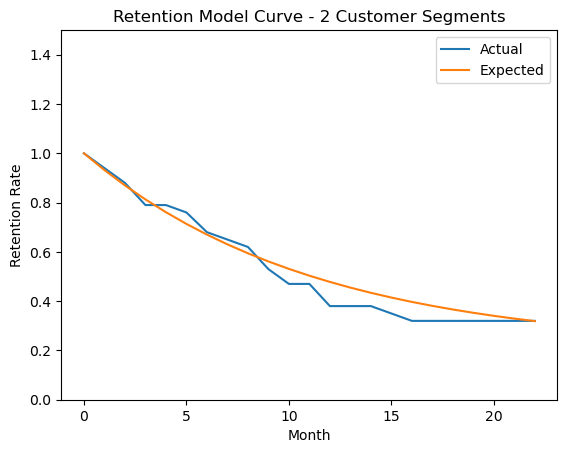

In [8]:
e_retention = (np.ones_like(retention) * (res.x[0]**month) * res.x[2]) + \
                (np.ones_like(retention) * (res.x[1]**month) * (1 - res.x[2]))
                
plt.plot(month, retention, label="Actual")
plt.plot(month, e_retention, label="Expected")
plt.title('Retention Model Curve - 2 Customer Segments')
plt.xlabel("Month")
plt.ylabel("Retention Rate")
plt.ylim((0,1.5))
plt.legend()

#### Non-Linear Least Square - 3 Customer Segments

In [9]:
# Observed retention curve
retention = alive/alive[0]
# Monthly loss
loss = alive[:-1] - alive[1:]

In [10]:
from scipy.optimize import minimize, LinearConstraint

def square_error(x):
    e_retention = (np.ones_like(retention) * (x[0]**month) * x[3]) + \
                  (np.ones_like(retention) * (x[1]**month) * x[4]) + \
                  (np.ones_like(retention) * (x[2]**month) * x[5])
    e_churn = e_retention[:-1] - e_retention[1:] 
    en_loss = e_churn * alive[0] 
    loss_error = np.sum((en_loss - loss)**2) 
    survivor_error = ((e_retention[-1] * alive[0]) - alive[-1])**2
    return loss_error + survivor_error

guesses = np.array([0.90, 0.90, 0.90, 0.20, 0.30, 0.50])
bnds = np.array([(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)])
cons = LinearConstraint([0, 0, 0, 1, 1, 1], 1, 1) # Define the constraint: x[3] + x[4] + x[5] <= 1
res = minimize(square_error, x0=guesses, bounds=bnds, constraints=[cons], method='trust-constr') 
print('Monthly Retention Rate - Segment 1 =', f'{res.x[0]:0.2%}')
print('% of Customer - Segment 1 =', f'{res.x[3]:0.2%}')
print('Monthly Retention Rate - Segment 2 =', f'{res.x[1]:0.2%}')
print('% of Customer - Segment 2 =', f'{res.x[4]:0.2%}')
print('Monthly Retention Rate - Segment 3 =', f'{res.x[2]:0.2%}')
print('% of Customer - Segment 3 =', f'{res.x[5]:0.2%}')
print('Sum of Squared Errors =', f'{res.fun:0.0f}')

Monthly Retention Rate - Segment 1 = 91.39%
% of Customer - Segment 1 = 40.38%
Monthly Retention Rate - Segment 2 = 91.39%
% of Customer - Segment 2 = 38.62%
Monthly Retention Rate - Segment 3 = 100.00%
% of Customer - Segment 3 = 21.00%
Sum of Squared Errors = 252951531


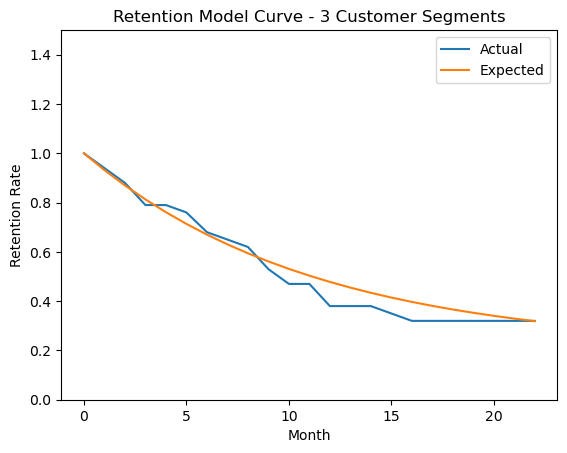

In [11]:
e_retention = (np.ones_like(retention) * (res.x[0]**month) * res.x[3]) + \
              (np.ones_like(retention) * (res.x[1]**month) * res.x[4]) + \
              (np.ones_like(retention) * (res.x[2]**month) * res.x[5])
                
plt.plot(month, retention, label="Actual")
plt.plot(month, e_retention, label="Expected")
plt.title('Retention Model Curve - 3 Customer Segments')
plt.xlabel("Month")
plt.ylabel("Retention Rate")
plt.ylim((0,1.5))
plt.legend()

In [12]:
from scipy.optimize import minimize, LinearConstraint

def square_error(x):
    e_retention = (np.ones_like(retention) * (x[0]**month) * x[3]) + \
                  (np.ones_like(retention) * (x[1]**month) * x[4]) + \
                  (np.ones_like(retention) * (x[2]**month) * (1-x[4]-x[3]))
    e_churn = e_retention[:-1] - e_retention[1:] 
    en_loss = e_churn * alive[0] 
    loss_error = np.sum((en_loss - loss)**2) 
    survivor_error = ((e_retention[-1] * alive[0]) - alive[-1])**2
    return loss_error + survivor_error

guesses = np.array([0.90, 0.90, 0.90, 0.20, 0.30])
bnds = np.array([(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)])
cons = LinearConstraint([0, 0, 0, 1, 1], 1, 1)
res = minimize(square_error, x0=guesses, bounds=bnds, constraints=[cons], method='COBYQA') 
print('Monthly Retention Rate - Segment 1 =', f'{res.x[0]:0.2%}')
print('% of Customer - Segment 1 =', f'{res.x[3]:0.2%}')
print('Monthly Retention Rate - Segment 2 =', f'{res.x[1]:0.2%}')
print('% of Customer - Segment 2 =', f'{res.x[4]:0.2%}')
print('Monthly Retention Rate - Segment 3 =', f'{res.x[2]:0.2%}')
print('% of Customer - Segment 3 =', f'{1-res.x[4]-res.x[3]:0.2%}')
print('Sum of Squared Errors =', f'{res.fun:0.0f}')

Monthly Retention Rate - Segment 1 = 100.00%
% of Customer - Segment 1 = 21.00%
Monthly Retention Rate - Segment 2 = 91.39%
% of Customer - Segment 2 = 79.00%
Monthly Retention Rate - Segment 3 = 14.64%
% of Customer - Segment 3 = 0.00%
Sum of Squared Errors = 252951531


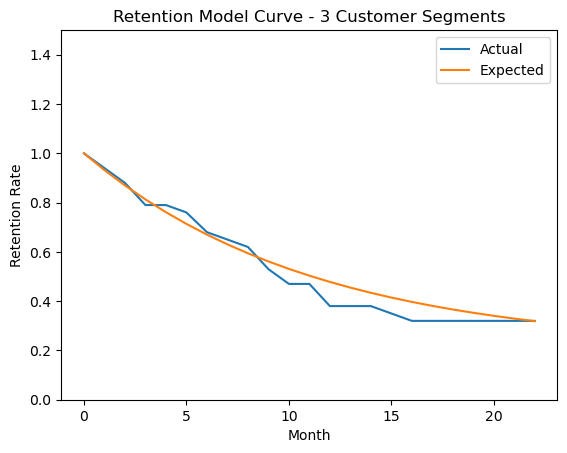

In [13]:
e_retention = (np.ones_like(retention) * (res.x[0]**month) * res.x[3]) + \
              (np.ones_like(retention) * (res.x[1]**month) * res.x[4]) + \
              (np.ones_like(retention) * (res.x[2]**month) * (1-res.x[4]-res.x[3]))
                
plt.plot(month, retention, label="Actual")
plt.plot(month, e_retention, label="Expected")
plt.title('Retention Model Curve - 3 Customer Segments')
plt.xlabel("Month")
plt.ylabel("Retention Rate")
plt.ylim((0,1.5))
plt.legend()

### Shifted Beta Geometric (sBG) Model 

The shifted beta geometric model (sBG) is a model that is used to forecast retention/survival of users in contractual settings (think netflix, disney plus, tinder gold, etc). The model is quite simple and posits:
- At the end of each period, a customer flips a coin: “heads” she cancels he contract, “tails” she renews it.
- For each individual, the probability of a coin coming up “heads” does not change over time
- The probability of heads varies across customers. 

The two things we need are the probability density function and the survival function. Mathematically, the probability density and survival function are:
$$P(T=t \mid \alpha, \beta) = \dfrac{B(\alpha+1, \beta+t-1)}{B(\alpha, \beta)}$$
$$S(T=t \mid \alpha, \beta) = \dfrac{B(\alpha, \beta+t)}{B(\alpha, \beta)}$$

Here, $B(\alpha, \beta)$ is the beta function and not the beta distribution.

#### Nonlinear Least Square (NLS) - One Segment Shifted Geometric (SG) Model 

In [14]:
month, alive = np.loadtxt('data/DSC-retention-data.csv', dtype='object', delimiter=',', unpack=True, skiprows=1) 
month = month.astype(int)
alive = alive.astype(float)

train_month = month[:8]
train_alive = alive[:8]

In [15]:
def square_error(theta):
    retention = train_alive / train_alive[0]
    e_retention = (1-theta)**train_month
    return np.sum((retention-e_retention)**2)

theta_guess = 0.5
res = minimize(square_error, theta_guess, bounds=[(0.000001,0.999999)])
theta = res.x[0]

(0.0, 1.1)

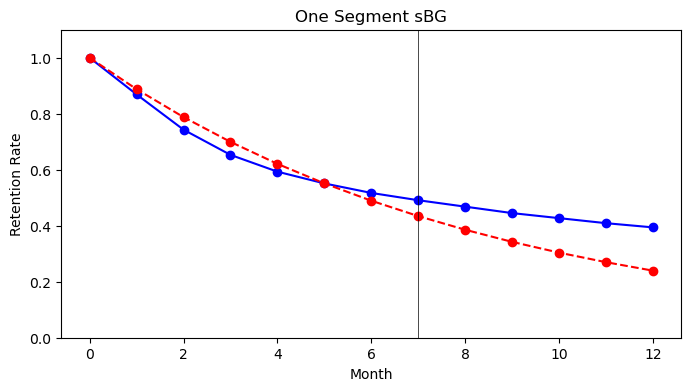

In [16]:
train_marker_x = [7 for _ in np.arange(0,1.2,0.1)]
train_marker_y = [_ for _ in np.arange(0,1.2,0.1)]

retention = alive / alive[0]
e_retention = (1-theta)**month

plt.figure(figsize=(8,4), dpi=100)
plt.plot(retention, "b-o")
plt.plot(e_retention, "r--o")
plt.plot(train_marker_x, train_marker_y, "k-", linewidth=0.5)
plt.title('One Segment sBG')
plt.xlabel("Month")
plt.ylabel("Retention Rate")
plt.ylim(0,1.1)

### Two Segment SG and Shifted-Beta-Geometric (sBG)